# Hydrostatics studies: exploring the _wetted surface area_ and _trim_ as functions of _center of gravity_ and _displacement mass_.

## Load the geometry file
![](models/hull.jpeg "Hull.stl")

In [2]:
### Load the geometry file
#!pip install https://github.com/LHEEA/meshmagick/archive/refs/tags/3.3.zip
import os
from meshmagick import mmio, mesh, hydrostatics

path = os.getcwd() + '/data/'
file = "hull.stl"

V, F = mmio.load_STL(path + file)
mymesh = mesh.Mesh(V, F)

# Check if the mesh is closed too:
print("Is it closed?", mymesh.is_mesh_closed())

# And inspect the mesh quality
mymesh.print_quality()

Is it closed? True

Triangle quality of the mesh (305804 elements):

 Area Ratio:
    range: 3.09206e-06  -  6.11828e-05
    average: 4.36635e-05  , standard deviation: 6.74992e-06
 Edge Ratio:
    range: 1.13053  -  4.76786
    average: 1.52945  , standard deviation: 0.163161
 Aspect Ratio:
    range: 1.05696  -  3.07106
    average: 1.40387  , standard deviation: 0.0607536
 Radius Ratio:
    range: 1.01303  -  2.66046
    average: 1.21676  , standard deviation: 0.0519023
 Frobenius Norm:
    range: 1.01136  -  2.81562
    average: 1.17175  , standard deviation: 0.054781
 Minimal Angle:
    range: 12.103  -  55.2776
    average: 41.3773  , standard deviation: 4.25725

Quadrilateral quality of the mesh (0 elements):

 Area Ratio:
    range: 0  -  0
    average: 0  , standard deviation: 0
 Edge Ratio:
    range: 0  -  0
    average: 0  , standard deviation: 0
 Aspect Ratio:
    range: 0  -  0
    average: 0  , standard deviation: 0
 Radius Ratio:
    range: 0  -  0
    average: 0  , sta

## Simulation with the hydrostatics solver
With the Mesh loaded we can create a simulation (using the hydrostatics solver) to get data to model the hull behaviour. We want to set the **displacement mass** (in TONS) and its **c.o.g.** (center of gravity) location ($x, y, z$ in meters, relative to the model's origin), and get the hull resulting **trim** and its **wetted surface area**.

In [ ]:
### Simulate:
# !pip install tqdm ipywidgets
# !jupyter nbextension enable --py widgetsnbextension
# !jupyter labextension install @jupyter-widgets/jupyterlab-manager
import pandas as pd
import numpy as np
from scipy.spatial.transform import Rotation as R
from meshmagick import densities
import multiprocessing as mp
from IPython.utils import io
from tqdm.autonotebook import tqdm

def simulate(mymesh, cog_x, mass, verbose=True):
    kg_to_tons = 1000
    disp = mass / kg_to_tons
    cog = np.array([cog_x, 0, 0])
    water_density = densities.get_density('SALT_WATER')
    grav = 9.81
    reltol = 1e-4
    z_corr, rotmat_corr = hydrostatics.full_equilibrium(mymesh,
                                                        cog,
                                                        disp,
                                                        water_density,
                                                        grav,
                                                        reltol=reltol,
                                                        verbose=verbose)
    hs_data = hydrostatics.compute_hydrostatics(mymesh,
                                                cog,
                                                water_density,
                                                grav,
                                                z_corr=z_corr,
                                                rotmat_corr=rotmat_corr,
                                                at_cog=True)

    mymesh.rotate_matrix(rotmat_corr)
    mymesh.translate_z(z_corr)

    r = R.from_matrix(hs_data['rotmat_eq'])
    angles_deg = r.as_euler('xyz', degrees=True)

    return {'disp_mass': hs_data['disp_mass'],
            'cog_x': hs_data['cog'][0],
            'cog_y': hs_data['cog'][1],
            'cog_z': hs_data['cog'][2],
            'wet_surface_area': hs_data['wet_surface_area'],
            'cob_x': hs_data['buoyancy_center'][0],
            'cob_y': hs_data['buoyancy_center'][1],
            'cob_z': hs_data['buoyancy_center'][2],
            'angles_deg_x': angles_deg[0],
            'angles_deg_y': angles_deg[1],
            'angles_deg_z': angles_deg[2],}

def parallel_simulate(args):
    VF, data = args
    mymesh = mesh.Mesh(*VF)

    with io.capture_output() as _: # Supress every text output from simulate
        try:
            result = simulate(mymesh, cog_x=data[0], mass=data[1], verbose=False)
        except(RuntimeError):
            result = None

        return result

points = 50
cogs_x = np.linspace(1, 4, points)
masses = np.linspace(200, 350, points)
input_data = np.array(np.meshgrid(cogs_x, masses)).T.reshape(-1,2)

results = []
with mp.Pool(min(mp.cpu_count(), len(input_data))) as pool:
    args = [((V, F), d) for d in input_data]
    results = list(tqdm(pool.imap(parallel_simulate, args), total=len(input_data)))

In [7]:
### Store the simulations's output to a file:
df = pd.DataFrame([r for r in results if r])
df.to_feather('meshmagick.feather')

## Load, Filter and Plot
To avoid some inconsistency on the dataset (for example, when the simulation doesn't converge), we can filter any abrupt angle in Y axis. We can consider only angles less than 10°.

,disp_mass,cog_x,cog_y,cog_z,wet_surface_area,cob_x,cob_y,cob_z,angles_deg_x,angles_deg_y,angles_deg_z
0,199.942908,1.0,0.0,0.0,2.646138,0.975620,1.698336e-07,-0.262960,-4.772127e-05,-5.087265,4.349773e-06
1,203.067466,1.0,0.0,0.0,2.660067,0.977218,-1.294537e-09,-0.262242,2.848866e-07,-5.124605,-2.620688e-08
2,206.084821,1.0,0.0,0.0,2.671003,0.975682,-1.057184e-09,-0.261273,2.384171e-07,-5.172162,-2.225170e-08
3,212.249147,1.0,0.0,0.0,2.695258,0.975816,-6.627520e-10,-0.259594,2.590549e-07,-5.261580,-2.446807e-08
4,215.297628,1.0,0.0,0.0,2.706899,0.975747,-7.852159e-10,-0.258755,1.813356e-07,-5.302108,-1.753551e-08
...,...,...,...,...,...,...,...,...,...,...,...
2488,337.746958,4.0,0.0,0.0,3.582398,4.021084,6.690615e-11,-0.251484,-2.975737e-08,4.795677,-1.951202e-09
2489,340.798772,4.0,0.0,0.0,3.595759,4.021387,7.276437e-11,-0.250728,-3.091066e-08,4.827429,-2.030457e-09
2490,343.888452,4.0,0.0,0.0,3.608867,4.021291,1.286474e-10,-0.249997,-4.342850e-08,4.858861,-3.115777e-09
2491,346.965446,4.0,0.0,0.0,3.622250,4.021272,6.664001e-11,-0.249263,-2.611994e-08,4.889769,-1.666865e-09


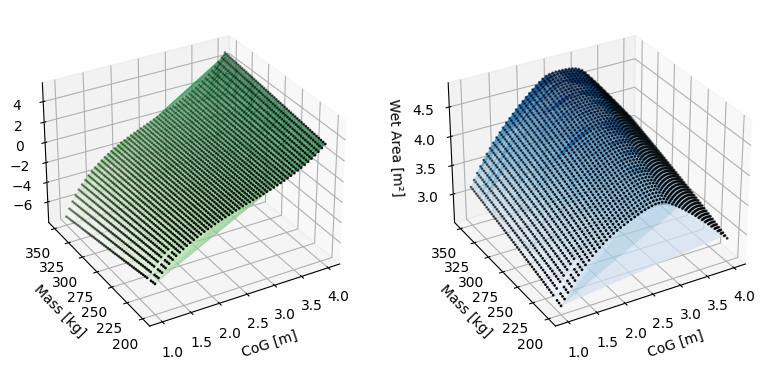

In [3]:
### Plot:
# %matplotlib notebook
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('default')

def load_dataset():
    df = pd.read_feather('data/meshmagick.feather')
    df = df[abs(df['angles_deg_y']) < 10].reset_index(drop=True)
    return df

def plot_dataset(df: pd.DataFrame):
    fig = plt.figure(figsize=plt.figaspect(1/2))

    X = df['cog_x']
    Y = df['disp_mass']

    Z = df['angles_deg_y']
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    ax.plot_trisurf(X, Y, Z, cmap='Greens', edgecolor=None, alpha=0.7)
    ax.scatter(X, Y, Z, c='black', s=1)
    ax.set_xlabel('CoG [m]')
    ax.set_ylabel('Mass [kg]')
    ax.set_zlabel('Trim [Deg]')
    ax.view_init(elev=30, azim=-120)

    Z = df['wet_surface_area']
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.plot_trisurf(X, Y, Z, cmap='Blues', edgecolor=None, alpha=0.7)
    ax.scatter(X, Y, Z, c='black', s=1)
    ax.set_xlabel('CoG [m]')
    ax.set_ylabel('Mass [kg]')
    ax.set_zlabel('Wet Area [m²]')
    ax.view_init(elev=30, azim=-120)

    plt.show()

df = load_dataset()
display(df)
plot_dataset(df)

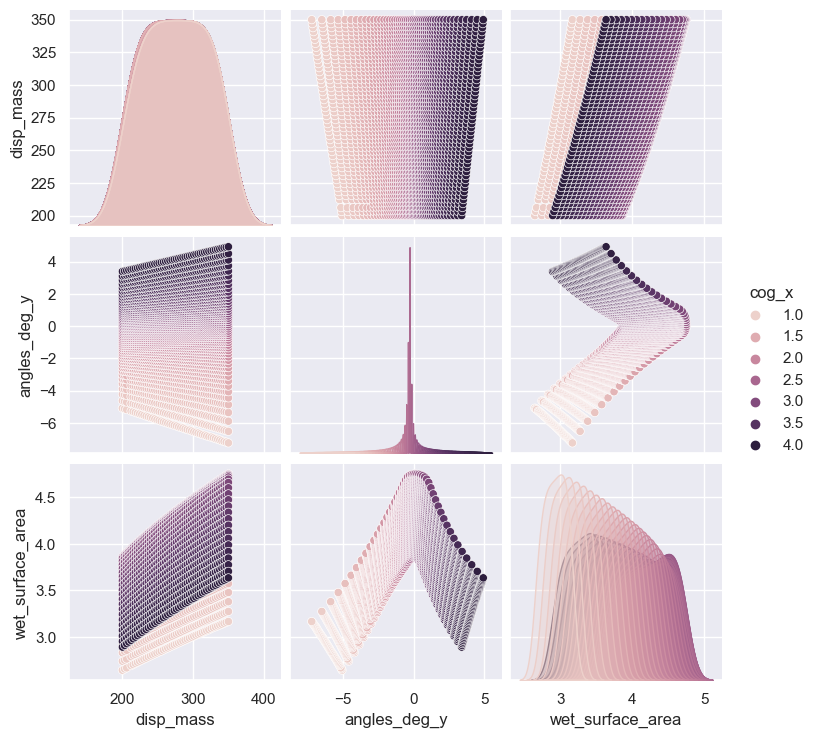

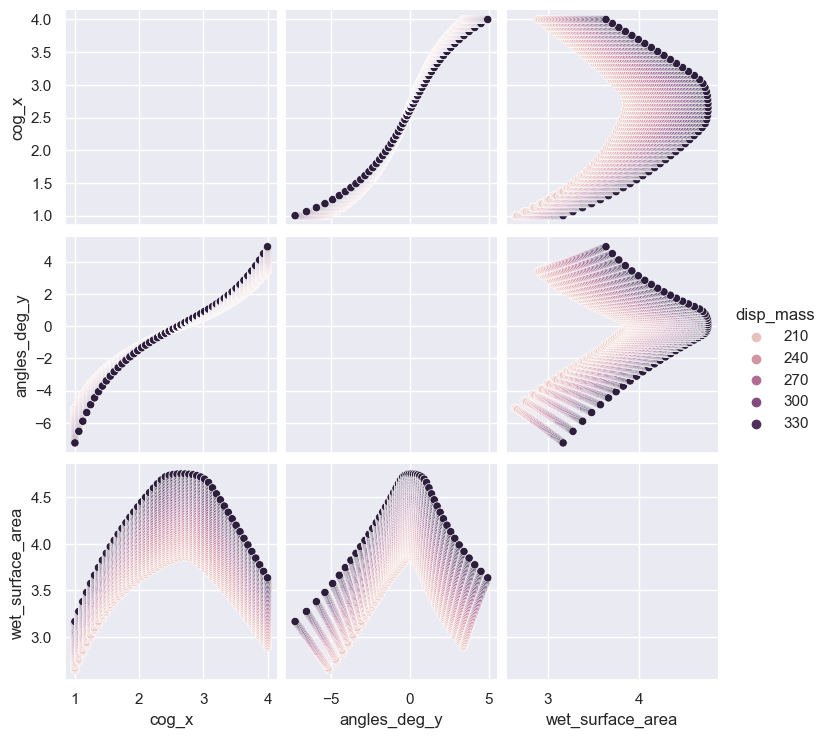

In [4]:
%matplotlib inline
import seaborn as sns
sns.set_theme()

sns.pairplot(df[['cog_x', 'disp_mass', 'angles_deg_y', 'wet_surface_area']], hue='cog_x')
plt.show()

sns.pairplot(df[['cog_x', 'disp_mass', 'angles_deg_y', 'wet_surface_area']], hue='disp_mass')
plt.show()

### Observations
- The greater the **displacement mass**, greater the **wetted surface area**;
- The **displacement mass** doesn't correlate well with the **y angle (trim)**;
- The greater the **cog x**, greater the **y angle (trim)**;
- The lowest **wetted surface area** occur with the **displacement mass**, but also with higher **cog x**;

## Visually understanding the change in CoG:

#### Case 1:
- mass = 265kg
- cog_x = 1m

![](models/hull_265kg_1m.jpeg)

In [11]:
mymesh = mesh.Mesh(V, F)
result = simulate(mymesh, mass=265, cog_x=1)
display(result)
# mymesh.show()

3DOF equilibrium
Target diplacement:    0.265 tons
COG pos:  [1 0 0]
	>>> Convergence reached in 7 iterations


{'disp_mass': 265.01987410262643,
 'cog_x': 1,
 'cog_y': 0,
 'cog_z': 0,
 'wet_surface_area': 2.8879710296999512,
 'cob_x': 0.9742873929075766,
 'cob_y': 1.1567261938275314e-10,
 'cob_z': -0.24527013892840835,
 'angles_deg_x': 2.2714341037050813e-08,
 'angles_deg_y': -6.030470300316568,
 'angles_deg_z': -3.1847102298117373e-09}

#### Case 2:
- mass = 265kg
- cog_x = 4m

![](models/hull_265kg_4m.jpeg)

In [12]:
mymesh = mesh.Mesh(V, F)
result = simulate(mymesh, mass=265, cog_x=4)
display(result)
# mymesh.show()

3DOF equilibrium
Target diplacement:    0.265 tons
COG pos:  [4 0 0]
	>>> Convergence reached in 6 iterations


{'disp_mass': 264.9905350089255,
 'cog_x': 4,
 'cog_y': 0,
 'cog_z': 0,
 'wet_surface_area': 3.243987177718191,
 'cob_x': 4.019042619185753,
 'cob_y': 1.0917872549528456e-10,
 'cob_z': -0.2694292624325621,
 'angles_deg_x': -4.637677478186538e-08,
 'angles_deg_y': 4.048640326769241,
 'angles_deg_z': -2.7388406473912666e-09}

# Modelling the hull (using sklearn):¶
We want to mathematically describe the relation as:
- `wet_surface_area = f(cog_x, disp_mass)`
- `angles_deg_y = f(cog_x, disp_mass)`

In [8]:
### PLOTTING:
import matplotlib.pyplot as plt

def plot_fitting(df, df_pred):
    plt.figure(figsize=(25,5))
    plt.plot(df['cog_x'], df_pred['wet_surface_area'], label='Model: Best Fit')
    plt.plot(df['cog_x'], df['wet_surface_area'], label='Data')
    plt.title('Wet Surface Area vs CoG')
    plt.xlabel('CoG [m]')
    plt.ylabel('Wet Surface Area [m²]')
    plt.legend()
    plt.show()

    plt.figure(figsize=(25,5))
    plt.plot(df['cog_x'], df_pred['angles_deg_y'], label='Model: Best Fit')
    plt.plot(df['cog_x'], df['angles_deg_y'], label='Data')
    plt.title('Angle vs CoG')
    plt.xlabel('CoG [m]')
    plt.ylabel('Angle [Deg]')
    plt.legend()
    plt.show()

    plt.figure(figsize=(25,5))
    plt.plot(df['disp_mass'], df_pred['wet_surface_area'], label='Model: Best Fit')
    plt.plot(df['disp_mass'], df['wet_surface_area'], label='Data')
    plt.title('Wet Surface Area vs Mass')
    plt.xlabel('Mass [kg]')
    plt.ylabel('Wet Surface Area [m²]')
    plt.legend()
    plt.show()

    plt.figure(figsize=(25,5))
    plt.plot(df['disp_mass'], df_pred['angles_deg_y'], label='Model: Best Fit')
    plt.plot(df['disp_mass'], df['angles_deg_y'], label='Data')
    plt.title('Angle vs Mass')
    plt.xlabel('Mass [kg]')
    plt.ylabel('Angle [Deg]')
    plt.legend()
    plt.show()

In [9]:
### MODELLING:
#!pip install numpy pandas sklearn
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error


# Load the dataset
df = load_dataset()

# Select the data
X = df[['cog_x', 'disp_mass']]
y = df[['wet_surface_area', 'angles_deg_y']]

# Build the Model
model = Pipeline([('preprocess', PolynomialFeatures(degree=3)),
                  ('model', LinearRegression(fit_intercept=True, n_jobs=16))])

# FIT the model to the data
model = model.fit(X, y)

# model.named_steps['linear'].coef_
y_pred = model.predict(X)
y_pred = pd.DataFrame({'wet_surface_area': y_pred[:,0],
                       'angles_deg_y': y_pred[:,1]})

# Evaluate
print('MAE:', mean_absolute_error(y, y_pred))
print('MSE:', mean_squared_error(y, y_pred))

### Print the model in a human readable format:
def polynomial_model_as_string(model, output_columns: list) -> str:
    feature_names_in = model.named_steps['preprocess'].feature_names_in_
    feature_names_out = model.named_steps['preprocess'].get_feature_names_out()
    coeffs = model.named_steps['model'].coef_

    funcs = []
    for output_index, output_name in enumerate(output_columns):
        func = f"{output_name}({', '.join(list(feature_names_in))}) = "
        for c, fno in zip(coeffs[output_index], feature_names_out):
            func += f" + (({c}) * ({fno.replace(' ', ' * ')}))"
        funcs.append(func)

    return funcs

for f in polynomial_model_as_string(model, y.columns):
    print('\n', f, end='\n')

MAE: 0.040621536751186946
MSE: 0.0033544584046866044

 wet_surface_area(cog_x, disp_mass) =  + ((0.0) * (1)) + ((0.9126418354117402) * (cog_x)) + ((0.004090308517881178) * (disp_mass)) + ((-0.10345389779578316) * (cog_x^2)) + ((0.005668272172661444) * (cog_x * disp_mass)) + ((-1.5089059442184062e-05) * (disp_mass^2)) + ((-0.02703007028937405) * (cog_x^3)) + ((-0.0008704317740474817) * (cog_x^2 * disp_mass)) + ((-1.2254949683428856e-06) * (cog_x * disp_mass^2)) + ((1.3409845123213415e-08) * (disp_mass^3))

 angles_deg_y(cog_x, disp_mass) =  + ((0.0) * (1)) + ((13.76097252844664) * (cog_x)) + ((-0.017531494742730983) * (disp_mass)) + ((-5.372865835321363) * (cog_x^2)) + ((0.00982989709359132) * (cog_x * disp_mass)) + ((-6.524155910139773e-06) * (disp_mass^2)) + ((0.7091476533534128) * (cog_x^3)) + ((-0.0008902927175727952) * (cog_x^2 * disp_mass)) + ((1.194271496113286e-06) * (cog_x * disp_mass^2)) + ((3.782529844897908e-09) * (disp_mass^3))


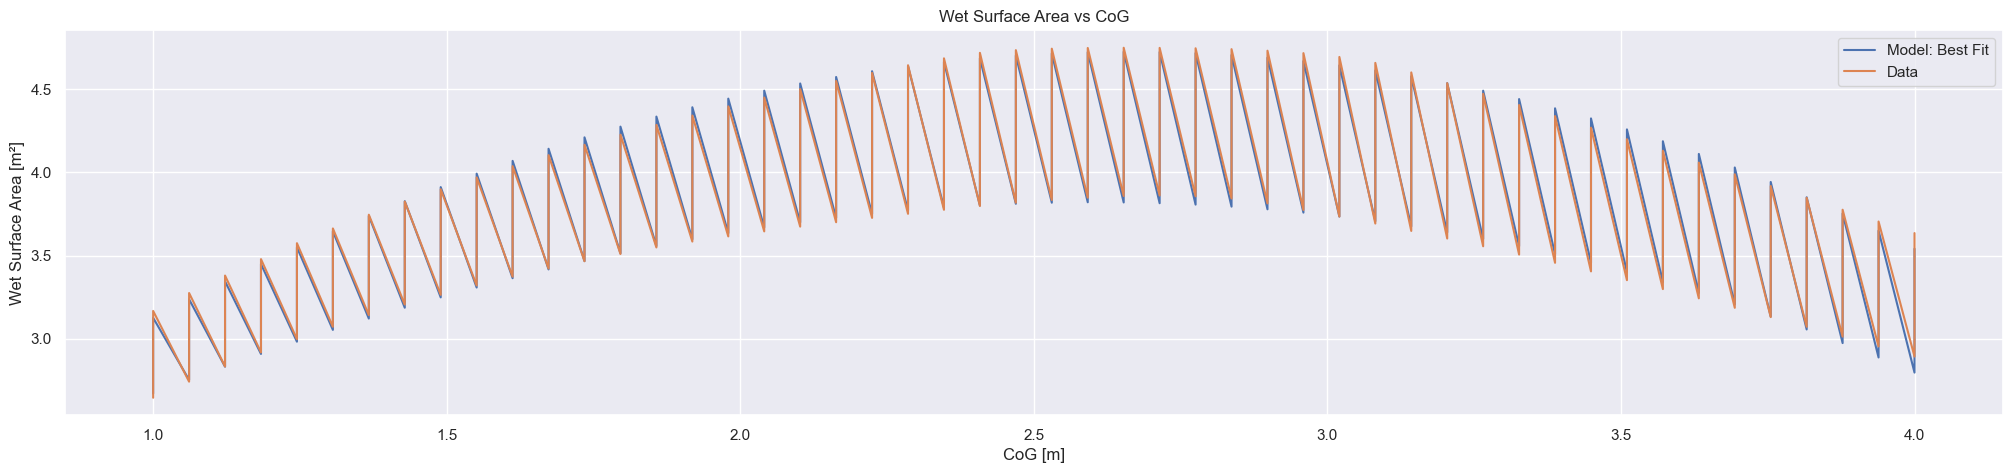

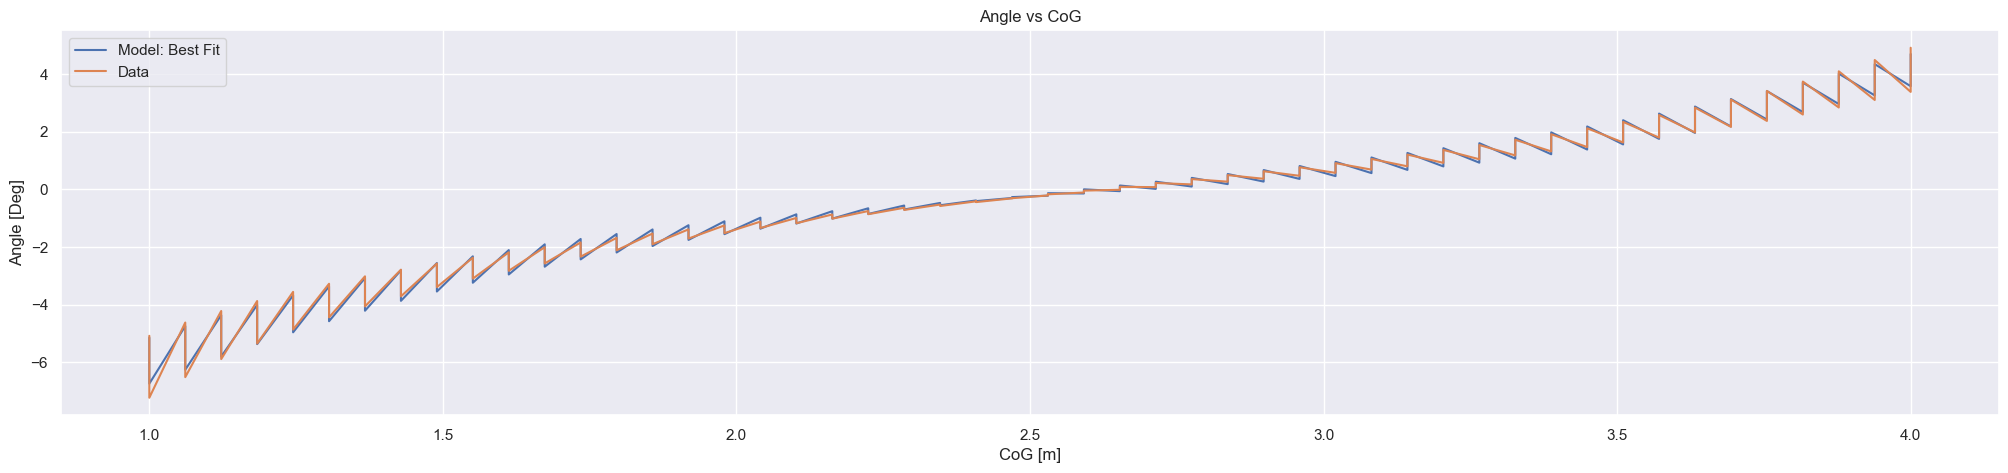

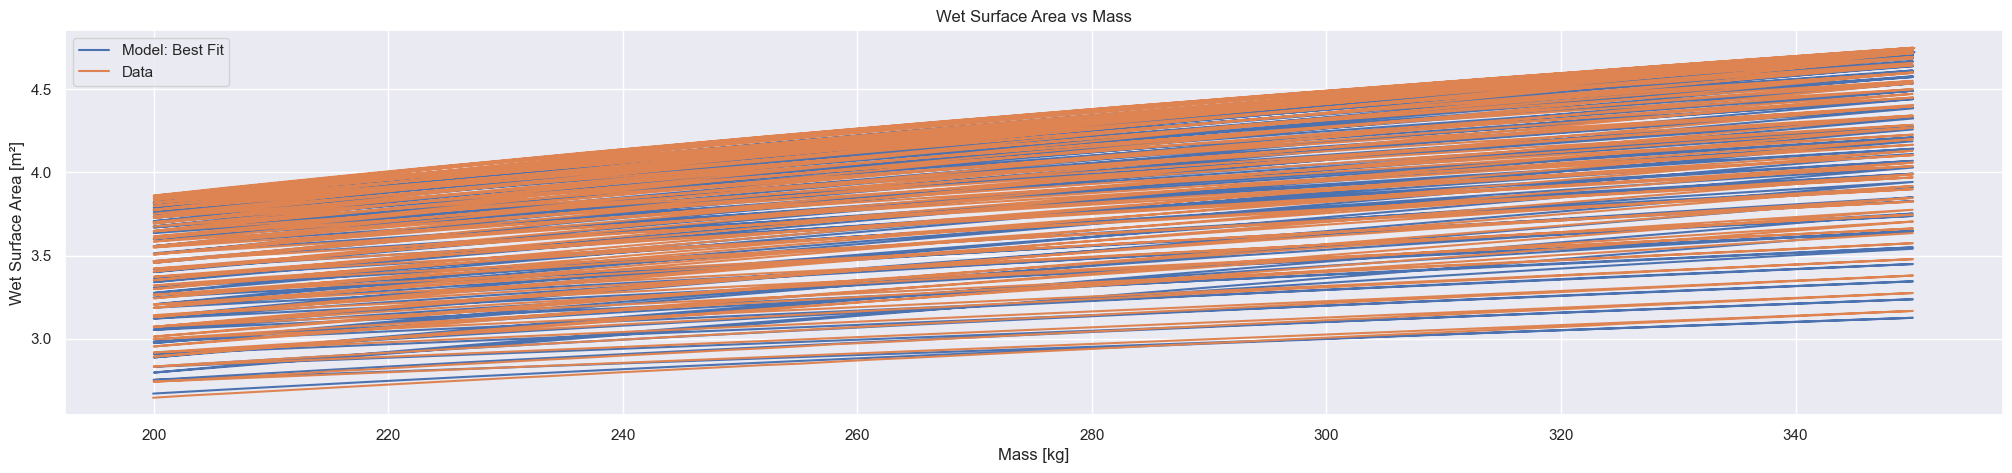

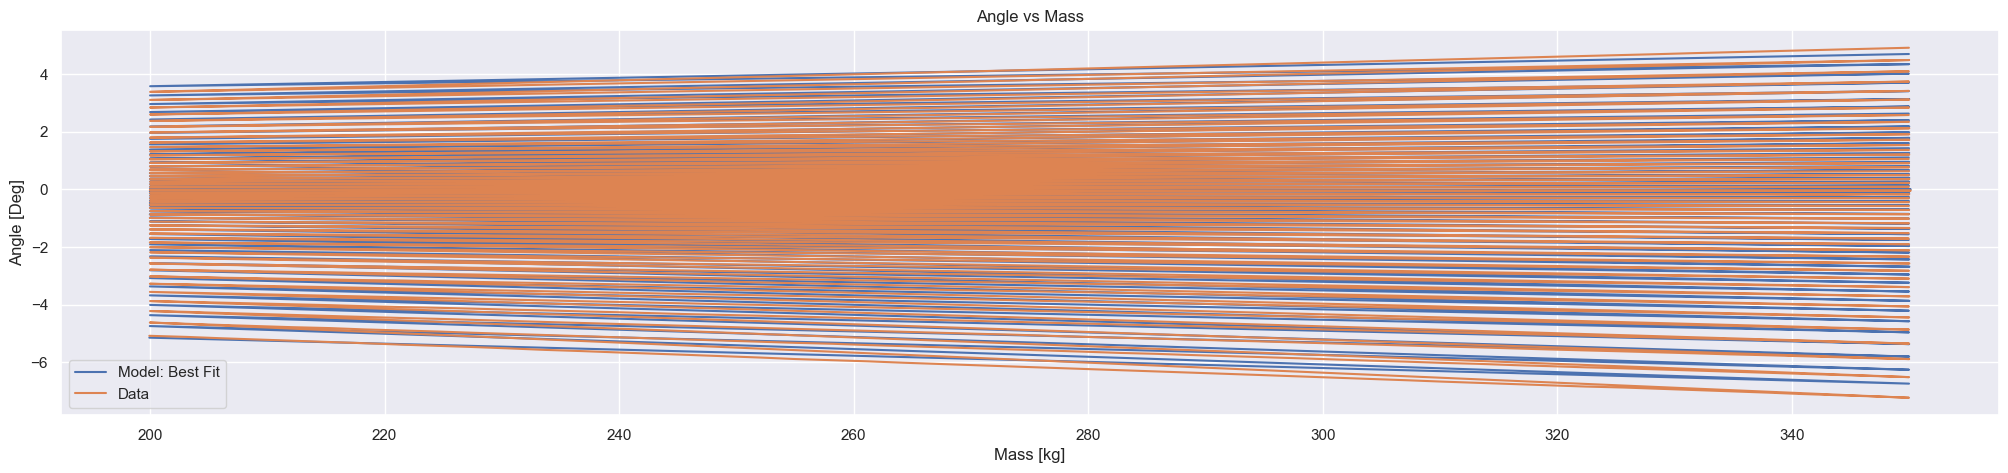

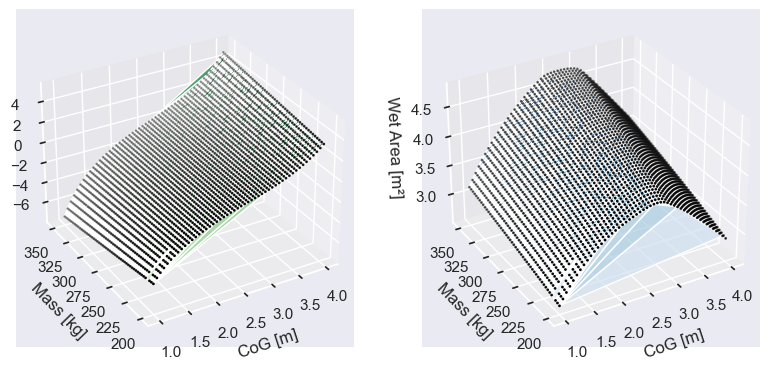

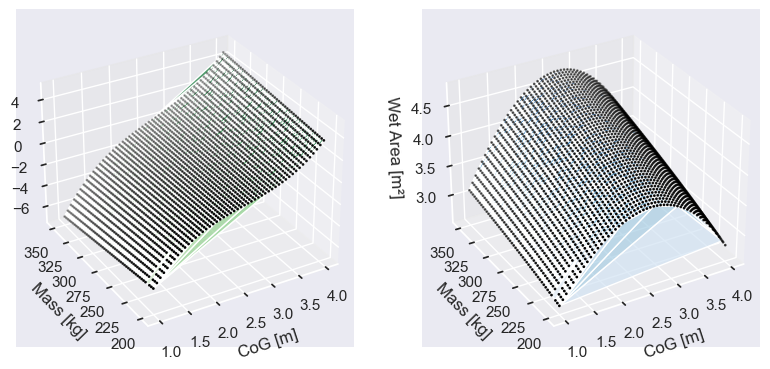

In [10]:
### PLOTTING:
plot_fitting(df, y_pred)

y_pred['cog_x'] = df['cog_x']
y_pred['disp_mass'] = df['disp_mass']

plot_dataset(df)
plot_dataset(y_pred)